<a href="https://colab.research.google.com/github/SChoi005/DeepLearningBasics/blob/main/tensorflow_serving.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

  # Tensorflow Serving

## Advandages of using TF Serving
* Scalability
* Low-latency
* Handles multiple models
* Handles multiple versions of the same model

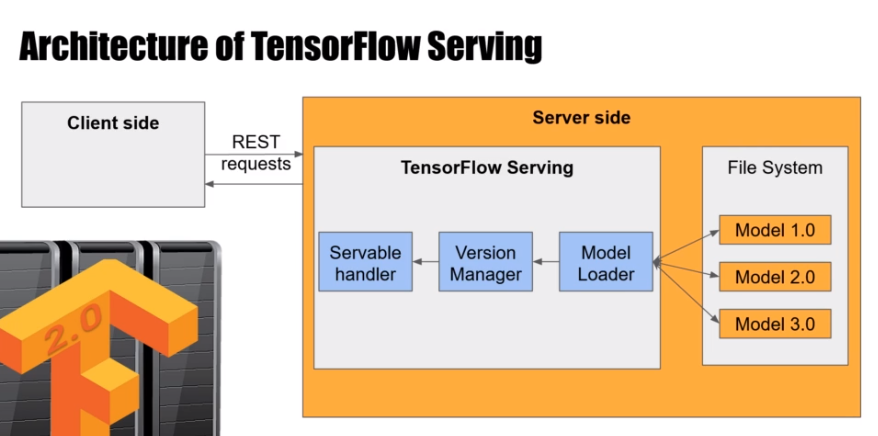

## Install dependecies and setting up GPU environment

In [ ]:
!echo "deb [arch=amd64] http://storage.googleapis.com/tensorflow-serving-apt stable tensorflow-model-server tensorflow-model-server-universal" | sudo tee /etc/apt/sources.list.d/tensorflow-serving.list && curl https://storage.googleapis.com/tensorflow-serving-apt/tensorflow-serving.release.pub.gpg | sudo apt-key add -

deb [arch=amd64] http://storage.googleapis.com/tensorflow-serving-apt stable tensorflow-model-server tensorflow-model-server-universal
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  2943  100  2943    0     0  34623      0 --:--:-- --:--:-- --:--:-- 34623
OK


In [ ]:
!apt-get update

Get:1 http://storage.googleapis.com/tensorflow-serving-apt stable InRelease [3,026 B]
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:3 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Hit:4 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:5 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Ign:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:7 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:8 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Get:9 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:10 http://storage.googleapis.com/tensorflow-serving-apt stable/tensorflow-model-server amd64 Packages [338 B]
Get:11 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Get:12 http://storage.googleapis.com/tensorflow

In [ ]:
!apt-get install tensorflow-model-server

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following NEW packages will be installed:
  tensorflow-model-server
0 upgraded, 1 newly installed, 0 to remove and 66 not upgraded.
Need to get 381 MB of archives.
After this operation, 0 B of additional disk space will be used.
Get:1 http://storage.googleapis.com/tensorflow-serving-apt stable/tensorflow-model-server amd64 tensorflow-model-server all 2.9.1 [381 MB]
Fetched 381 MB in 5s (70.4 MB/s)
Selecting previously unselected package tensorflow-model-server.
(Reading database ... 155639 files and directories currently installed.)
Preparing to unpack .../tensorflow-model-server_2.9.1_all.deb ...
Unpacking tensorflow-model-server (2.9.1) ...
Setting up tensorflow-model-server (2.9.1) ...


In [ ]:
!pip uninstall tensorflow

Found existing installation: tensorflow 2.8.2+zzzcolab20220527125636
Uninstalling tensorflow-2.8.2+zzzcolab20220527125636:
  Would remove:
    /usr/local/bin/estimator_ckpt_converter
    /usr/local/bin/import_pb_to_tensorboard
    /usr/local/bin/saved_model_cli
    /usr/local/bin/tensorboard
    /usr/local/bin/tf_upgrade_v2
    /usr/local/bin/tflite_convert
    /usr/local/bin/toco
    /usr/local/bin/toco_from_protos
    /usr/local/lib/python3.7/dist-packages/tensorflow-2.8.2+zzzcolab20220527125636.dist-info/*
    /usr/local/lib/python3.7/dist-packages/tensorflow/*
Proceed (y/n)? y
  Successfully uninstalled tensorflow-2.8.2+zzzcolab20220527125636


In [ ]:
# 텐서플로우 2.0은 serving을 잘 지원을안함
!pip install tensorflow-gpu==1.13.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 345.0 MB 3.8 kB/s 
     |████████████████████████████████| 3.2 MB 7.5 MB/s 
     |████████████████████████████████| 50 kB 8.1 MB/s 
     |████████████████████████████████| 367 kB 66.8 MB/s 
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.8.0
    Uninstalling tensorflow-estimator-2.8.0:
      Successfully uninstalled tensorflow-estimator-2.8.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.8.0
    Uninstalling tensorboard-2.8.0:
      Successfully uninstalled tensorboard-2.8.0


In [ ]:
!pip install requests

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Import project dependencies

In [ ]:
import os
import json
import random
import requests
import subprocess
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras.datasets import cifar10

%matplotlib inline
tf.__version__

'1.13.1'

## Dataset preprocessing

In [ ]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

170500096/170498071 [==============================] - 2s 0us/step


In [ ]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [ ]:
X_train = X_train / 255.0
X_test = X_test / 255.0

In [ ]:
X_train.shape

(50000, 32, 32, 3)

## Defining the model 

In [ ]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding="same", activation="relu", input_shape=[32, 32, 3]))
model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding="same", activation="relu"))
model.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2, padding='valid'))
model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=3, padding="same", activation="relu"))
model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=3, padding="same", activation="relu"))
model.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2, padding='valid'))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(units=128, activation='relu'))
model.add(tf.keras.layers.Dense(units=10, activation='softmax'))

Instructions for updating:
Colocations handled automatically by placer.


In [ ]:
model.compile(optimizer='Adam', 
              loss='sparse_categorical_crossentropy', 
              metrics=['sparse_categorical_accuracy'])

In [ ]:
model.fit(X_train, 
          y_train, 
          batch_size=128, 
          epochs=10)

Epoch 1/10
50000/50000 [==============================] - 11s 225us/sample - loss: 1.5163 - sparse_categorical_accuracy: 0.4525
Epoch 2/10
50000/50000 [==============================] - 5s 100us/sample - loss: 1.0186 - sparse_categorical_accuracy: 0.6431
Epoch 3/10
50000/50000 [==============================] - 5s 97us/sample - loss: 0.8326 - sparse_categorical_accuracy: 0.7108
Epoch 4/10
50000/50000 [==============================] - 5s 97us/sample - loss: 0.7163 - sparse_categorical_accuracy: 0.7513
Epoch 5/10
50000/50000 [==============================] - 5s 97us/sample - loss: 0.6275 - sparse_categorical_accuracy: 0.7832
Epoch 6/10
50000/50000 [==============================] - 5s 102us/sample - loss: 0.5428 - sparse_categorical_accuracy: 0.8129
Epoch 7/10
50000/50000 [==============================] - 7s 140us/sample - loss: 0.4768 - sparse_categorical_accuracy: 0.8349
Epoch 8/10
50000/50000 [==============================] - 5s 97us/sample - loss: 0.4079 - sparse_categorical_accu

In [ ]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)

10000/10000 [==============================] - 1s 85us/sample - loss: 0.9231 - sparse_categorical_accuracy: 0.7375


In [ ]:
print("Test accuracy is {}".format(test_accuracy))

Test accuracy is 0.737500011920929


## Saving the model for production

In [ ]:
# Creating the directory for the model
MODEL_DIR = "model/"
version = 1

In [ ]:
export_path = os.path.join(MODEL_DIR, str(version))
export_path

'model/1'

In [ ]:
if os.path.isdir(export_path):
    !rm -r {export_path}

In [ ]:
# Saving the model for the TensorFlow Serving
#tf.compat.v1.disable_eager_execution()
tf.saved_model.simple_save(tf.keras.backend.get_session(), export_dir=export_path, inputs={"input_image":model.input}, outputs={t.name:t for t in model.outputs})

Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.simple_save.
Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.utils.build_tensor_info or tf.compat.v1.saved_model.build_tensor_info.
INFO:tensorflow:Assets added to graph.
INFO:tensorflow:No assets to write.
INFO:tensorflow:SavedModel written to: model/1/saved_model.pb


## Setting up the production environment

In [ ]:
# Exporting the MODEL_DIR to environment variables
os.environ['MODEL_DIR'] = os.path.abspath(MODEL_DIR)

In [ ]:
!wget 'http://storage.googleapis.com/tensorflow-serving-apt/pool/tensorflow-model-server-universal-2.8.0/t/tensorflow-model-server-universal/tensorflow-model-server-universal_2.8.0_all.deb'

--2022-07-11 13:20:14--  http://storage.googleapis.com/tensorflow-serving-apt/pool/tensorflow-model-server-universal-2.8.0/t/tensorflow-model-server-universal/tensorflow-model-server-universal_2.8.0_all.deb
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.192.128, 209.85.147.128, 142.250.125.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.192.128|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 335421916 (320M) [application/x-debian-package]
Saving to: ‘tensorflow-model-server-universal_2.8.0_all.deb’

tensorflow-model-se 100%[===================>] 319.88M  94.4MB/s    in 3.4s    

2022-07-11 13:20:18 (94.4 MB/s) - ‘tensorflow-model-server-universal_2.8.0_all.deb’ saved [335421916/335421916]



In [ ]:
!dpkg -i tensorflow-model-server-universal_2.8.0_all.deb

Selecting previously unselected package tensorflow-model-server-universal.
(Reading database ... 155640 files and directories currently installed.)
Preparing to unpack tensorflow-model-server-universal_2.8.0_all.deb ...
Unpacking tensorflow-model-server-universal (2.8.0) ...
dpkg: error processing archive tensorflow-model-server-universal_2.8.0_all.deb (--install):
 trying to overwrite '/usr/bin/tensorflow_model_server', which is also in package tensorflow-model-server 2.9.1
dpkg-deb: error: paste subprocess was killed by signal (Broken pipe)
Errors were encountered while processing:
 tensorflow-model-server-universal_2.8.0_all.deb


In [ ]:
%%bash --bg
nohup tensorflow_model_server \
 --rest_api_port=8501 \
 --model_name=cifar10 \
 --model_base_path="${MODEL_DIR}" >server.log 2>&1

Starting job # 2 in a separate thread.


In [ ]:
!sudo find / -name "libm.so.6"

/lib/x86_64-linux-gnu/libm.so.6
find: ‘/proc/27/task/27/net’: Invalid argument
find: ‘/proc/27/net’: Invalid argument
/lib32/libm.so.6


In [ ]:
!tail server.log

tensorflow_model_server: /lib/x86_64-linux-gnu/libc.so.6: version `GLIBC_2.28' not found (required by tensorflow_model_server)
tensorflow_model_server: /usr/lib/x86_64-linux-gnu/libstdc++.so.6: version `GLIBCXX_3.4.26' not found (required by tensorflow_model_server)
tensorflow_model_server: /lib/x86_64-linux-gnu/libm.so.6: version `GLIBC_2.29' not found (required by tensorflow_model_server)


## Creating the first POST request

In [ ]:
random_image = np.random.randint(0, len(X_test))
random_image

5051

In [ ]:
# Creating the JSON data object
data = json.dumps({"signature":"serving_default", "instances":[X_test[random_image].tolist()]})

In [ ]:
data

'{"signature": "serving_default", "instances": [[[[0.7686274509803922, 0.8705882352941177, 0.9098039215686274], [0.8, 0.8941176470588236, 0.9254901960784314], [0.8509803921568627, 0.9294117647058824, 0.9490196078431372], [0.8901960784313725, 0.9647058823529412, 0.9803921568627451], [0.8941176470588236, 0.9686274509803922, 0.9882352941176471], [0.8941176470588236, 0.9686274509803922, 0.984313725490196], [0.8901960784313725, 0.9647058823529412, 0.9803921568627451], [0.8941176470588236, 0.9686274509803922, 0.984313725490196], [0.8980392156862745, 0.9725490196078431, 0.984313725490196], [0.8980392156862745, 0.9725490196078431, 0.9882352941176471], [0.9019607843137255, 0.9764705882352941, 0.9882352941176471], [0.8941176470588236, 0.9725490196078431, 0.984313725490196], [0.9019607843137255, 0.9764705882352941, 0.984313725490196], [0.8392156862745098, 0.8901960784313725, 0.8627450980392157], [0.49411764705882355, 0.5450980392156862, 0.4745098039215686], [0.3568627450980392, 0.3882352941176470

In [ ]:
# Sending the first POST request to the model
headers = {"content-type":"application/json"}

In [ ]:
json_response = requests.post(url="http://localhost:8501/v1/models/cifar10:predict",data=data, headers=headers)

ConnectionError: ignored

In [ ]:
json_response

In [ ]:
predictions = json.loads(json_response.test)['predictions']

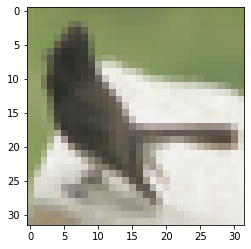

In [ ]:
plt.imshow(X_test[random_image])

In [ ]:
class_names[np.argmax(predictions[0])]

## Sending the POST request to a specific model

In [ ]:
specific_json_response = requests.post(url="http://localhost:8501/v1/models/cifar10/versions/1:predict", data=data, headers=headers)

In [ ]:
specific_json_response